# Working with Databases in UETOOLS

Because there only is one block of memory allocated for UEDGE in every Python prompt, restoring several cases in the same session is to be avoided, and may not even be possible for some combinations of cases. Thus, one of the most important functionalities of UETOOLS is to provide the user with tools for creating, analyzing, and processing databases consisting of several UEDGE simulations. This Chapter explains how to work with Databases using UETOOLS.


## TOC:
* [Creating Databases](#creating)
    * [From specified files](#from-files)
    * [From an input file](#from-input)
    * [From a folder](#from-folder)
* [Managing Databases](#managing)
    * [Concatenating Databases](#concatenating)
    * [Sorting Databases](#sorting)
    * [Rewriting Databases](#rewriting)
    * [Closing Databases](#closing)
* [Accessing Databases data using Database.get](#accessing-data)
* [Accessing individual Case objects](#accessing-cases)
    * [Cases by key](#by-key)
    * [Cases by index](#by-sorting-index)
    * [Cases by sorting value](#by-value)
* [Plotting trends](#plotting-trends)
    * [Pre-defined plots](#pre-defined)
    * [General plotting functions](#general)
* [Two-dimensional plots](#2d-plotting)
    * [Interactive 2D plots](#interactive)

In [1]:
# Move to the folder containing the parameter scans
from time import sleep
from os import chdir
chdir('testcase_lores')
from uetools import Database

## Creating Databases<a class="anchor" id="creating"></a>
UETOOLS Databases are design to be generated directly from UETOOLS save files. UETOOLS saves contain the most commonly accessed and used UEDGE parameters by default, but additional data can be stored in saves. See Chapter 8 for more information on UETOOLS saves. The primary function of Database objects is to read UEDGE data from pre-defined UETOOLS save files, but also provides some additional capabilities as outlined below. In order to traverse and handle large databases, Database object miniminizes the data stored in memory, and utilizes the HDF5 save files as databases, where data is retrieved from whenever requested. Consequently, Database objects will keep open all HDF5 files included in the database. 

Databases can be generated from UETOOLS save files using the three methods outlined below.

### Creating a Database from specified files<a class="anchor" id="from-files"></a>
The most direct way to create a database is to initialize the Database object with a list of files to be included:

In [2]:
db_list = Database(['nc20.hdf5', 'SUCCESS_ncore_down.hdf5'])

The cases are stored in Database.cases as a dictionaries, where the keys are are the paths to the files, without the ".hdf5" extension and each dictionary object is Case-object created using the inplave=True option: 

In [3]:
db_list.cases.keys()

dict_keys(['SUCCESS_ncore_down', 'nc20'])

### Creating a Database from an input file<a class="anchor" id="from-input"></a>
Databases can also be defined by reading a plain-text file that lists the paths to the Cases to be included. The Case-definition file should only contain the paths to the files to be included on individual lines. Comments, denoted by "#" can be included on separate lines or as inline comments, too.

In [4]:
!cat filelist.txt

# Define files

ncore_down_ncore=1.400e+19_last_ii2.hdf5 # Inline comments work, too
ncore_down_ncore=1.500e+19_last_ii2.hdf5
ncore_down_ncore=1.600e+19_last_ii2.hdf5
ncore_down_ncore=1.700e+19_last_ii2.hdf5
ncore_down_ncore=1.800e+19_last_ii2.hdf5
ncore_down_ncore=1.900e+19_last_ii2.hdf5


In [5]:
db_file = Database('filelist.txt')

### Creating a Database based on a folder<a class="anchor" id="from-folder"></a>
Finally, databases can also be created by recursively searching a folder for any UETOOLS-compatible HDF5 files. This is done by creating the Database object with a path to the folder to recursively search. Any folders named "ignore" will be omitted from the recursive search.

In [6]:
db = Database('ncore_down')

## Managing Databases<a class="anchor" id="managing"></a>

### Concatenating Databases<a class="anchor" id="concatenating"></a>
Databases can be concatenated into one another if necessary

In [7]:
print("# of cases before: ", len(db.cases))
db.concatenate([db_file, db_list])
print("# of cases after: ", len(db.cases))

# of cases before:  14
# of cases after:  22


The same sorting (see below) as used when creating the parent Database object is applied to the concatenated Database.

### Sorting Databases<a class="anchor" id="sorting"></a>
The UEDGE simulations included in a Database object can be ordered according to different criteria, which may be a consideration when plotting and/or accessing the data. The function Database.sort() provides sorting functionality for the database objects:

In [8]:
help(db.sort)

Help on method sort in module uetools.UeDatabase.Database:

sort(variable, location='OMPsep', increasing=True, species=None, varname=None) method of uetools.UeDatabase.Database.Database instance
    Sorts cases according to variable at location
    
    Note: This works because python dict preserves the order
    of insertion (since python 3.7).



The required argument for Database.sort is the variable to be sorted, which can be either a string of a valid variable name from the UETOOLS save file (see Chapter 8 for details) or an array of length equal to the length of the case dictionary Database.cases.

If the variable supplied is a UEDGE case name, the sorting routine accesses the data for each Case included in the database and sorts the data according to the grid location specified by the kwarg "location". The variable "location" can be an index (for 1D arrays in the individual Case objects, e.g. "igaso") or a tuple specifying the grid location (for 2D arrays in individual Case objects, e.g. "ne"). The kwarg "location" is ignored if the variable is a float/int in the individual Case objects (e.g. "pcoree"). For sorting 2D arrays defined on the UEDGE grid, a number of special "location" keywords are available:
- OMPsep: the outer-midplane in the first flux-tube radially outside the separatrix
- ITsep: the HFS target in the first flux-tube radially outside the separatrix
- OTsep: the LFS target in the first flux-tube radially outside the separatrix
- ITmin: minimum value of the variable at the HFS target 
- OTmin: minimum value of the variable at the LFS target 
- ITmax: maximum value of the variable at the HFS target 
- OTmax: maximum value of the variable at the LFS target 

Not that all the above options are dynamically detected for each individual case. Thus, using the keywords will always detect the correct location for each case, even if the Case objects in the database have different grid resolution. If "location" is specified as a tuple, the same (ix,iy) location will be used for the sort for each case, independent of the actual grid dimensions.

If "variable" is a list, the dictionary Database.cases will be re-ordered based on the values in the list. This option is useful if you need to order the list based on derived parameters as it can be combined with Database.get (see below) e.g. to calculate the total input power pcoree+pcorei. In case "variable" is a list or array, "varname" (string) defines the name of the variable the sort is performed for, which is used when plotting (see below). 

The kwarg "increasing" (boolean) is used to determine whether to sort in ascending (True) or descending (False) order. When sorting by multi-species arrays (e.g. ni, ng), the kwarg species is used to define the species index. 

By default, Database is sorted upon creation by the electron density at the LFS miplane location:

In [9]:
db.sort("ne", "OMPsep")

The sorting variable and locations used when creating a Database object can be controlled by the kwargs "sortvar" and "sortlocation". In case "sortvar" is amulti-species array, the species index is controlled by the kwarg "sortspecies".

Information about the sorting is stored to Database.sortlabel, which attempts to define the variable and location used to sort the data and Database.sortvalues containing the array of sorted values. Additional data, which may be usedul is stored to the Database object in Database.increasesort, Database.sortspecies, Database.sortvar, Database.sortlocation

### Rewriting Database Cases<a class="anchor" id="rewriting"></a>
The Database object can be used to re-write the save-files used to create subseqeunt Database objects. This is a useful functionality when one needs to include additional data into the save-file, which was not previously written (see Chapter 8). In this case, the database can be re-run with the kwarg rerun=True (default: rerun=False). 

When rerun=True, the Database object will be created based on the arguments as described above. However, before creating the database, a new save-file will be written according to the current Case specification. This functionality may be used to write additional data to the files, which one needs to access through the Database object, if this data was not available previously.

The re-writte save-files will be created in the directory specified by the "rerun_dir" kwarg (default: rerun_dir="UeDB_rerun"), preserving the folder structure of the original database. In case rerun_dir=None, the new cases will be created in the same location as the intial save file, but distinguished by appending the string specified by "dbidentifier" (default: dbidentifier="\_UeDB") to the save name.


In [10]:
new_db=Database('ncore_down', rerun=True, rerun_dir='ncore_down_rerun')

===== CREATING NEW CASE DUMPS =====
Restoring case from HDF5 file:
  Rate dirs read from .uedgerc
  Grid read from ncore_down/progress0p916_dtrun_last_ii2.hdf5
  User-specified diffusivities read from HDF5 file
Restoring case from HDF5 file:
  Rate dirs read from .uedgerc
  Grid read from ncore_down/progress0p180.hdf5
  User-specified diffusivities read from HDF5 file
Restoring case from HDF5 file:
  Rate dirs read from .uedgerc
  Grid read from ncore_down/progress0p151_dtrun_last_ii2.hdf5
  User-specified diffusivities read from HDF5 file
Restoring case from HDF5 file:
  Rate dirs read from .uedgerc
  Grid read from ncore_down/progress0p262.hdf5
  User-specified diffusivities read from HDF5 file
Restoring case from HDF5 file:
  Rate dirs read from .uedgerc
  Grid read from ncore_down/progress0p947.hdf5
  User-specified diffusivities read from HDF5 file
Restoring case from HDF5 file:
  Rate dirs read from .uedgerc
  Grid read from ncore_down/progress0p993_dtrun_last_ii2.hdf5
  User-spe

In [10]:
!ls -lrt | tail -1
!ls ncore_down_rerun/

drwxr-xr-x  16 holm10  27647     512 Feb  5 17:41 ncore_down_rerun
progress0p001_UeDB.hdf5                progress0p458_UeDB.hdf5
progress0p011_UeDB.hdf5                progress0p880_dtrun_last_ii2_UeDB.hdf5
progress0p037_UeDB.hdf5                progress0p896_UeDB.hdf5
progress0p099_UeDB.hdf5                progress0p916_dtrun_last_ii2_UeDB.hdf5
progress0p151_dtrun_last_ii2_UeDB.hdf5 progress0p947_UeDB.hdf5
progress0p180_UeDB.hdf5                progress0p993_dtrun_last_ii2_UeDB.hdf5
progress0p262_UeDB.hdf5                progress1p000_staticiter_UeDB.hdf5


**WARNING:** it is strongly recommended to always use the kwargs dbidentifier and rerun_dir to avoid read/write conflicts, which may result in the save failing, which may wipe the new save-file. In cases where rerun_dir=None and dbidentifier="", there is a risk of corrupting the original save-files.

**NOTE:** As noted above, Database objects will open, and keep open, the UETOOLS save files used to compile the database. This also applies to the newly created files if rerun=True. Thus, subsequent reruns from/into the same save files may result in read/write errors. To avoid such situations, it is recommended to only use rerun=True individually in new Python sessions.

### Closing open save files<a class="anchor" id="closing"></a>
As noted above, the Database objects keeps the save files open to avoid populating memory. The save files can be closed by the function Databases.closedb, which will close all open HDF5 objects which makes them accessible to external functions. The local objects will, however, be inaccessible from here on and, due to the functionality of the h5py module, cannot be re-opened in the same session.


## Accessing Database data using Database.get<a class="anchor" id="accessing-data"></a>

The data available in a database is defined by the data written to the save files according to the YAML definition file (see Chapter 8). Any such data can be accessed via the Database object using the function Database.get. Database.get returns the requested data in an array concatenated along the first dimension, the remaining dimension being defined by the shape of the requested array:

In [11]:
print("# of cases in Database: ", len(db.cases))
print("Shape of ni-array: ", db.get("ni").shape)

# of cases in Database:  22
Shape of ni-array:  (22, 18, 10, 8)


Thus, the first dimension length equals the number of cases in the database, whereas the remaining indices are determined by variable (in this case, determined by com.nx+2, com.ny+2, and com.nisp). 

## Accessing individual Case objects<a class="anchor" id="accessing-cases"></a>
As mentioned above, the Database object creates a dictionary of Case objects, which is used to access the data. Thus, Case-objects can be directly accessed via the Database object, and any function present in Case objects can be used. 

### Accessing a Case object by key<a class="anchor" id="by-key"></a>
Case objects can be directly accessed by their keys:

In [12]:
print(db.cases['nc20'])

### Accessing a Case by its sorted index<a class="anchor" id="by-sorting-index"></a>
Cases objects can also be accessed by their order in the sorted list (see above). This can be useful when one just needs to access some genreal Case-function, but do not know which keys are present in the dictionary. A case can be accessed based on index by Database.getcase:

In [13]:
print(db.getcase(0))

The Case objects can then be used as normal:

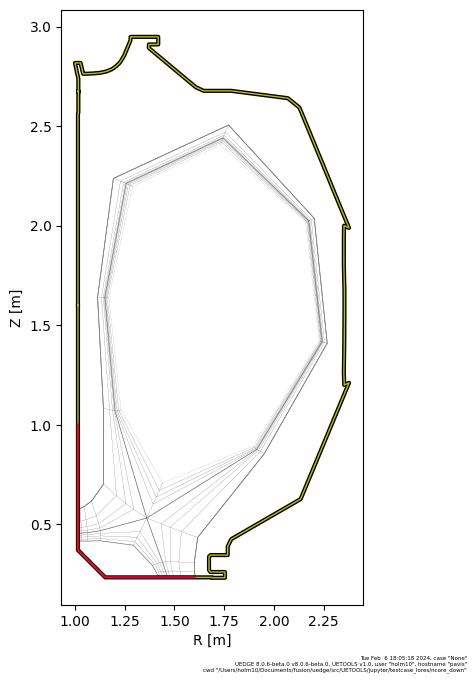

In [14]:
db.getcase(0).grid();

### Accessing the case closest matching a value<a class="anchor" id="by-value"></a>
When looking at trends, it may be useful to access the Case object closest to some specific parameter value. This is possible using the functions Database.get_closest and Database.get_closest_key which return the Case object and Case object keynin Database.cases, respectively, but are otherwise identical:

In [15]:
help(db.get_closest_key)

Help on method get_closest_key in module uetools.UeDatabase.Database:

get_closest_key(target, var=None, index=None, species=None) method of uetools.UeDatabase.Database.Database instance



The functions will look for and return the case with "var" closest to "target", which is the only required argument. If the kwarg "var" is not specified, the function will use the values used to sort the Database object, e.g. the LFS midplane electron density at the first flux-tube radially outside the separatrix by default:

In [16]:
print(db.get_closest_key(1e19))

ncore_down/progress0p458


The function can also be used to look for the closest matches of other variables if "var" is the name of a valid variabel (e.g. stored in the save files, see Chapter 8). If the variable has more than one dimension, kwarg "index" must be specified as an integer or tuple defining the index/location of var to be used. If the requested variable is a multi-species variable, the kwarg "species" must also be specified.

In [17]:
print(db.get_closest_key(1e20, "ni", index=(-2, 5), species=0))

ncore_down_ncore=1.800e+19_last_ii2


Finally, cases can also be accessed by being closes to a user-defined list, which is useful when looking for derived or dynamic parameters, (such as, e.g., the peak target density):

In [18]:
from numpy import max # Use numpy's max as it can search along individual axes
print(db.get_closest_key(1e20, max(db.get("ne")[:,-2], axis=1)))

ncore_down_ncore=1.500e+19_last_ii2


## Plotting trends using Database objects<a class="anchor" id="plotting-trends"></a>

The most straightforward use of Database objects is to create 1D-plots highlighting the dependency on some variable upon another. The Database object contains a number of pre-defined functions for this purpose

### Pre-defined plotting functions:<a class="anchor" id="pre-defined"></a>

There is a number of pre-defined routines for plotting trends in the Database object. All of these functions plot a given parameter at a specific location agains the variable the Database is sorted against. 


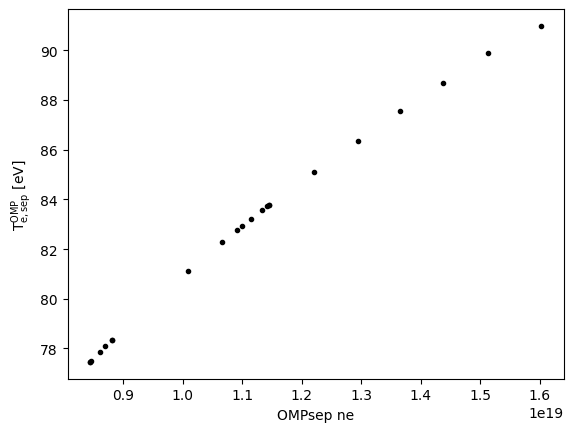

In [19]:
db.teOMP();

The pre-defined functions are utilize the plot-functions described below, and any valid kwargs for any of the parent function, up to the underlying Axes.plot function, can be passed to the pre-defined functions. As before, multi-species plots require the additional argument for the species index to be plotted:

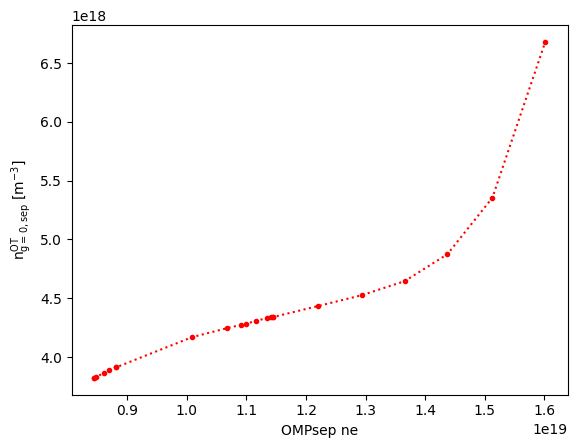

In [20]:
db.ngOTsep(0, color='r', linestyle=':');

The full list of available pre-defined functions is shown below:

In [21]:
funcs = []
for s in dir(db):
    if (("OT" in s) or ("IT" in s) or ("OMP" in s)) and ("plot" not in s):
        funcs.append(s)
funcs.sort()
for func in funcs:
    print(func)

neITmax
neITsep
neOMP
neOTmax
neOTsep
ngITmax
ngITsep
ngOMP
ngOTmax
ngOTsep
niITmax
niITsep
niOMP
niOTmax
niOTsep
teITmax
teITsep
teOMP
teOTmax
teOTsep
tgITmax
tgITsep
tgOMP
tgOTmax
tgOTsep
tiITmax
tiITsep
tiOMP
tiOTmax
tiOTsep


Here, IT and OT defines the location as the inner and outer targets, respectively. The definition sep refers to the first flux-tube radially outside the separatrix of the defined location, and max to the max value along the defined location. OMP refers to the first cell radially outside the separatrix at the LFS midplane. 

### General plotting functions<a class="anchor" id="general"></a>
The pre-defined plotting functions described above are based upon a number of location-dependent hepler functions, listed below:

In [22]:
funcs = []
for s in dir(db):
    if (("OT" in s) or ("IT" in s) or ("OMP" in s)) and ("plot" in s):
        funcs.append(s)
funcs.sort()
for func in funcs:
    print(func)

plotITmax
plotITsep
plotOMP
plotOTmax
plotOTsep


In [23]:
help(db.plotOTsep)

Help on method plotOTsep in module uetools.UeDatabase.DB_1Dplots:

plotOTsep(var, **kwargs) method of uetools.UeDatabase.Database.Database instance



The above functions take Database.get output as arguments and plots the requested location form the variable array. 

In [24]:
help(db.plotOTmax)

Help on method plotOTmax in module uetools.UeDatabase.DB_1Dplots:

plotOTmax(var, inds=(None, None), **kwargs) method of uetools.UeDatabase.Database.Database instance



The plot\*max-functions can also be supplied the additional kwarg inds, which limits the search interval along the defined location to slice(\*inds).

**NOTE:** The current implementation does not handle different-sized grids, and will pick the same location in index-space for all Case objects.

All of the above functions then call Database.plotscan, which plots variables against the sorting-variable:

In [25]:
help(db.plotscan)

Help on method plotscan in module uetools.UeDatabase.DB_1Dplots:

plotscan(var, location=(), **kwargs) method of uetools.UeDatabase.Database.Database instance



Database.plotscan can be supplied the kwarg "location" by a tuple compatible with the variable dimensions. Database.plotscan, in turn, calls the function Database.plotvar:

In [26]:
help(db.plotvar)

Help on method plotvar in module uetools.UeDatabase.DB_1Dplots:

plotvar(xvar, yvar, ax=None, xlabel=None, ylabel=None, marker='.', linestyle='', color='k', **kwargs) method of uetools.UeDatabase.Database.Database instance
    Plots yvar as a function of xvar for all cases



Database.plotvar is a simple wrapper for creating a pyplot figure and calling Axes.plot, which is supplied any kwargs.

## Two-dimensional plotting<a class="anchor" id="2d-plotting"></a>
It is recommended that individual Case objects, accessible by the above functions, are used to plot 2D plots (see Chapter 3). The Database object does, however, offer some interactive plotting functions, which can be used to investigate trends in 2D.

### Interactive 2D plots<a class="anchor" id="interactive"></a>
There is a number of interactive 2D plots available via Database objects. These functions are unavailable through Jupyter, but can be used in interactive sessions via the Python prompt. The pre-defined functions are listed below:

In [27]:
for s in dir(db):
    if ("2D" in s) and ("plot" not in s):
        print(s)

ne_2Dseries
ng_2Dseries
ni_2Dseries
te_2Dseries
tg_2Dseries
ti_2Dseries


In [28]:
help(db.ne_2Dseries)

Help on method ne_2Dseries in module uetools.UeDatabase.DB_2Dplots:

ne_2Dseries(**kwargs) method of uetools.UeDatabase.Database.Database instance



Any kwargs supplied to the interactive plots are passed to the Case.plotmesh (see Chapter 3). Below is a figure of showing the output of ne_2Dseries:

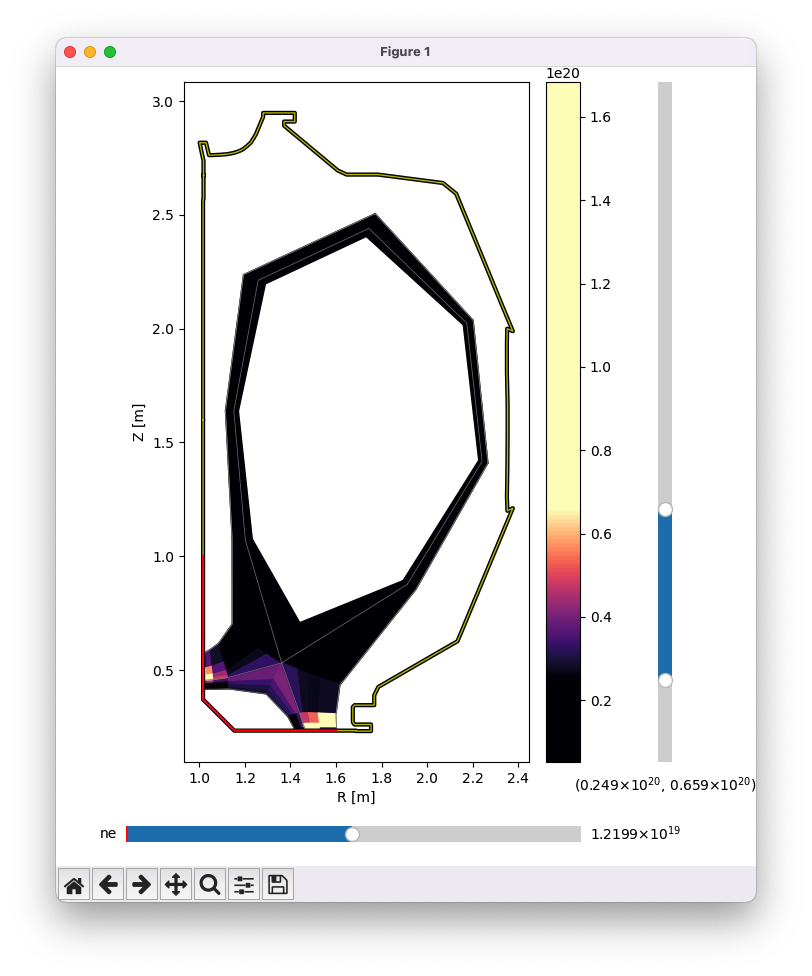

**NOTE:** The interactive 2D functions are not compatible with different meshes in the same Database.

Each of the pre-defined interactive plots call the function Database.plot_2Dseries:

In [29]:
help(db.plot_2Dseries)

Help on method plot_2Dseries in module uetools.UeDatabase.DB_2Dplots:

plot_2Dseries(vararray, **kwargs) method of uetools.UeDatabase.Database.Database instance
    Returns a series of figures to scroll through



Database.plot_2Dseries can be supplied by any 3-dimensional array, where the first dimension matches the number of cases in the Database object and the two following the gird dimensions, such as the output of Database.get, accounting for any multi-species arrays by selecting the appropriate species.